In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import numpy as np

from typing import Union, List, Tuple

In [85]:
class SSResidualUnit(nn.Module):
    
    def __init__(self, channels:int, dilation:int):
        
        super(SSResidualUnit, self).__init__()
        
        self.channels = channels
        self.dilation = dilation
        
        self.sequence = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=7, dilation=dilation, padding="same"),
            nn.ELU(),
            nn.Conv1d(channels, channels, kernel_size=1, padding="same")
        )
        
    def forward(self, x):
        h = self.sequence(x)
        return x + h
    
s = SSResidualUnit(2, 1)
x = torch.randn((1, 2, 64))
s(x).shape

torch.Size([1, 2, 64])

In [131]:
class SSEncoderBlock(nn.Module):
    
    def __init__(self, channels:int, stride:int):
        
        super(SSEncoderBlock, self).__init__()
        
        self.channels = channels
        self.stride = stride
        
        self.resid_0 = SSResidualUnit(self.channels // 2, dilation = 1)
        self.resid_1 = SSResidualUnit(self.channels // 2, dilation = 3)
        self.resid_2 = SSResidualUnit(self.channels // 2, dilation = 9)
        
        self.out_conv = nn.Conv1d(self.channels // 2, self.channels, kernel_size=2*self.stride, stride=self.stride, padding=self.stride//2)
        
    def forward(self, x):
        x0 = self.resid_0(x)
        x1 = self.resid_0(x0)
        x2 = self.resid_0(x1)
        out = self.out_conv(x2)
        
        return out
    
se = SSEncoderBlock(4, 2)
x = torch.randn((1, 2, 4096))
se(x).shape

torch.Size([1, 4, 2048])

In [87]:
class SSEncoder(nn.Module):
    
    def __init__(self, in_channels:int, channels:int, embedding_dims:int):
        
        super(SSEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.channels = channels
        self.embedding_dims = embedding_dims
        
        self.in_conv = nn.Conv1d(self.in_channels, self.channels, kernel_size=7, padding=3)
        
        self.encoder_block_0 = SSEncoderBlock(self.channels * 2, 2)
        self.encoder_block_1 = SSEncoderBlock(self.channels * 4, 4)
        self.encoder_block_2 = SSEncoderBlock(self.channels * 8, 5)
        self.encoder_block_3 = SSEncoderBlock(self.channels * 16, 8)
        
        self.out_conv = nn.Conv1d(self.channels * 16, self.embedding_dims, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        
        h = self.in_conv(x)
        h0 = self.encoder_block_0(h)
        h1 = self.encoder_block_1(h0)
        h2 = self.encoder_block_2(h1)
        h3 = self.encoder_block_3(h2)
        
        out = self.out_conv(h3)
        
        return out
    
sse = SSEncoder(1, 4, 128)
sse(torch.randn(1, 1, 128*128)).shape

torch.Size([1, 128, 51])

In [125]:
class SSDecoderBlock(nn.Module):
    
    def __init__(self, channels:int, stride:int):
        
        super(SSDecoderBlock, self).__init__()
        
        self.channels = channels
        self.stride = stride
        
        self.in_conv = nn.ConvTranspose1d(self.channels, self.channels // 2, kernel_size=2*self.stride, stride=self.stride, padding=self.stride//2)
        
        self.resid_0 = SSResidualUnit(self.channels // 2, dilation = 1)
        self.resid_1 = SSResidualUnit(self.channels // 2, dilation = 3)
        self.resid_2 = SSResidualUnit(self.channels // 2, dilation = 9)
        
    def forward(self, x):
        x0 = self.in_conv(x)
        x1 = self.resid_0(x0)
        x2 = self.resid_1(x1)
        out = self.resid_2(x2)
        
        return out
    
se = SSDecoderBlock(8, 2)
x = torch.randn((1, 8, 64))
se(x).shape

torch.Size([1, 4, 128])

In [122]:
4*122, 8*64

(488, 512)

In [100]:
class SSDecoder(nn.Module):
    
    def __init__(self, out_channels:int, channels:int, embedding_dims:int):
        
        super(SSDecoder, self).__init__()
        
        self.out_channels = out_channels
        self.channels = channels
        self.embedding_dims = embedding_dims
        
        self.in_conv = nn.Conv1d(self.embedding_dims, self.channels * 8, kernel_size=7, stride=1, padding=3)
        
        self.encoder_block_0 = SSDecoderBlock(self.channels * 8, 8)
        self.encoder_block_1 = SSDecoderBlock(self.channels * 4, 5)
        self.encoder_block_2 = SSDecoderBlock(self.channels * 2, 4)
        self.encoder_block_3 = SSDecoderBlock(self.channels, 2)
        
        self.out_conv = nn.Conv1d(self.channels // 2, self.out_channels, kernel_size=7, padding=3)
        
    def forward(self, x):
        
        h = self.in_conv(x)
        
        h0 = self.encoder_block_0(h)
        h1 = self.encoder_block_1(h0)
        h2 = self.encoder_block_2(h1)
        h3 = self.encoder_block_3(h2)
        out = self.out_conv(h3)
        
        return out
    
dec = SSDecoder(1, 8, 512)
x = torch.randn((1, 512, 51))
dec(x).shape

torch.Size([1, 1, 16328])

In [54]:
# this is not the quantizer they used, just a simple one for experimenting
class EmbeddingQuantizer(nn.Module):

    def __init__(self, codebook_size:int, embedding_dims:int) -> None:
        
        super(EmbeddingQuantizer, self).__init__()

        self.embedding_dims = embedding_dims
        self.codebook_size = codebook_size

        self.embeddings = nn.Embedding(self.codebook_size, self.embedding_dims)

    def forward(self, x):

        B, C, T = x.shape

        reshape_inputs = x.permute(0, 2, 1).contiguous() # embed by channel values (BTC)
        reshape_inputs = reshape_inputs.view(-1, self.embedding_dims) # reshape to embedding dimensions (B, E)

        # calculate distances between all inputs and embeddings
        xs = (reshape_inputs**2).sum(dim=1, keepdim=True)
        ys = (self.embeddings.weight**2).sum(dim=1)
        dots = reshape_inputs @ self.embeddings.weight.t()
        distances = (xs + ys) - (2 * dots)

        # get embedding indices and quantize
        embedding_indexes = torch.argmin(distances, dim=1).unsqueeze(1)
        quantized_embeddings = self.embeddings(embedding_indexes).view(B, T, C).permute(0, 2, 1).contiguous()

        loss = F.mse_loss(x, quantized_embeddings)

        return quantized_embeddings, embedding_indexes.squeeze(-1), loss

eq = EmbeddingQuantizer(1024, 128)
x = torch.randn((1, 128, 51))
embs, codes, loss = eq(x)
embs.shape

torch.Size([1, 128, 51])

In [160]:
class SoundStream(nn.Module):
    
    def __init__(self, in_channels:int, channels:int, embedding_dims:int, codebook_size:int):
        
        super(SoundStream, self).__init__()
        
        self.encoder = SSEncoder(in_channels, channels, embedding_dims)
        self.quantizer = EmbeddingQuantizer(codebook_size, embedding_dims)
        self.decoder = SSDecoder(in_channels, channels, embedding_dims)
        
    def forward(self, x):
        
        h = self.encoder(x)
        embs, codes, q_loss = self.quantizer(h)
        out = self.decoder(embs)
        
        return out, embs, codes, q_loss
    
model = SoundStream(1, 4, 128, 512)
x = torch.randn(1, 1, 22050)
out, embs, codes, q_loss = model(x)
x.shape, out.shape, embs.shape, codes, q_loss

(torch.Size([1, 1, 22050]),
 torch.Size([1, 1, 21768]),
 torch.Size([1, 128, 68]),
 tensor([171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171,
         171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171,
         171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171,
         171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171,
         171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171]),
 tensor(0.6877, grad_fn=<MseLossBackward0>))

In [162]:
# not using stft for now
import librosa

x = librosa.load('../data/song_01.wav')
x = torch.tensor(x[0])


In [163]:
sample_size = 21768
cutoff = x.shape[0] - (x.shape[0] % sample_size)
xs = x[:cutoff].view(-1, sample_size)
xs = xs[:,None,...]
xs.shape

torch.Size([170, 1, 21768])

In [164]:
model(xs[:3])[0].shape

torch.Size([3, 1, 21768])

In [172]:
from IPython.display import Audio

sr = 22050
Audio(xs[61].squeeze().tolist(), rate=sr)

In [186]:
device = "cuda:1"
model = SoundStream(1, 4, 128, 512)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
steps = 1000
pbar = tqdm(total=steps)
losses = []
BATCH_SIZE = 16

for i in range(steps):
    pbar.update(1)
    batch_ix = torch.randint(0, xs.shape[0], (BATCH_SIZE,))
    inputs = xs[batch_ix].to(device)
    out, embs, codes, q_loss = model(inputs)

    recon_loss = criterion(out, inputs)
    loss = q_loss + recon_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    pbar.set_description(desc=f"average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

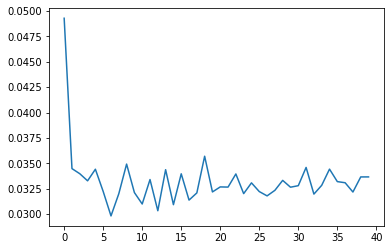

In [180]:
plt.plot(torch.tensor(losses).view(-1, 25).mean(1))

In [264]:
# from https://github.com/facebookresearch/denoiser/blob/main/denoiser/stft_loss.py

def stft(x, fft_size, hop_size, win_length, window):
    """Perform STFT and convert to magnitude spectrogram.
    Args:
        x (Tensor): Input signal tensor (B, T).
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length.
        window (str): Window function type.
    Returns:
        Tensor: Magnitude spectrogram (B, #frames, fft_size // 2 + 1).
    """
    window = window.to(x.device)
    x_stft = torch.stft(x, fft_size, hop_size, win_length, window)
    real = x_stft[..., 0]
    imag = x_stft[..., 1]

    # NOTE(kan-bayashi): clamp is needed to avoid nan or inf
    return torch.sqrt(torch.clamp(real ** 2 + imag ** 2, min=1e-7)).transpose(2, 1)


class LogSTFTMagnitudeLoss(torch.nn.Module):
    """Log STFT magnitude loss module."""

    def __init__(self):
        """Initilize los STFT magnitude loss module."""
        super(LogSTFTMagnitudeLoss, self).__init__()

    def forward(self, x_mag, y_mag):
        """Calculate forward propagation.
        Args:
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Log STFT magnitude loss value.
        """
        return F.l1_loss(torch.log(y_mag), torch.log(x_mag))

class SpectralConvergengeLoss(torch.nn.Module):
    """Spectral convergence loss module."""

    def __init__(self):
        """Initilize spectral convergence loss module."""
        super(SpectralConvergengeLoss, self).__init__()

    def forward(self, x_mag, y_mag):
        """Calculate forward propagation.
        Args:
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return torch.norm(y_mag - x_mag, p="fro") / torch.norm(y_mag, p="fro")

class STFTLoss(torch.nn.Module):
    """STFT loss module."""

    def __init__(self, fft_size=64, shift_size=16, win_length=32, window="hann_window"):
        """Initialize STFT loss module."""
        super(STFTLoss, self).__init__()
        self.fft_size = fft_size
        self.shift_size = shift_size
        self.win_length = win_length
        self.register_buffer("window", getattr(torch, window)(win_length))
        self.spectral_convergenge_loss = SpectralConvergengeLoss()
        self.log_stft_magnitude_loss = LogSTFTMagnitudeLoss()

    def forward(self, x, y):
        """Calculate forward propagation.
        Args:
            x (Tensor): Predicted signal (B, T).
            y (Tensor): Groundtruth signal (B, T).
        Returns:
            Tensor: Spectral convergence loss value.
            Tensor: Log STFT magnitude loss value.
        """
        x_mag = stft(x, self.fft_size, self.shift_size, self.win_length, self.window)
        y_mag = stft(y, self.fft_size, self.shift_size, self.win_length, self.window)
        sc_loss = self.spectral_convergenge_loss(x_mag, y_mag)
        mag_loss = self.log_stft_magnitude_loss(x_mag, y_mag)

        return sc_loss, mag_loss

class MultiResolutionSTFTLoss(torch.nn.Module):
    """Multi resolution STFT loss module."""

    def __init__(self,
                 fft_sizes=[1024, 2048, 512, 256, 128, 64, 32, 16],
                 hop_sizes=[120, 240, 50, 25, 12, 6, 3, 2],
                 win_lengths=[600, 1200, 240, 128, 64, 32, 16, 8],
                 window="hann_window", factor_sc=0.1, factor_mag=0.1):
        """Initialize Multi resolution STFT loss module.
        Args:
            fft_sizes (list): List of FFT sizes.
            hop_sizes (list): List of hop sizes.
            win_lengths (list): List of window lengths.
            window (str): Window function type.
            factor (float): a balancing factor across different losses.
        """
        super(MultiResolutionSTFTLoss, self).__init__()
        assert len(fft_sizes) == len(hop_sizes) == len(win_lengths)
        self.stft_losses = torch.nn.ModuleList()
        for fs, ss, wl in zip(fft_sizes, hop_sizes, win_lengths):
            self.stft_losses += [STFTLoss(fs, ss, wl, window)]
        self.factor_sc = factor_sc
        self.factor_mag = factor_mag

    def forward(self, x, y):
        """Calculate forward propagation.
        Args:
            x (Tensor): Predicted signal (B, T).
            y (Tensor): Groundtruth signal (B, T).
        Returns:
            Tensor: Multi resolution spectral convergence loss value.
            Tensor: Multi resolution log STFT magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for f in self.stft_losses:
            sc_l, mag_l = f(x, y)
            sc_loss += sc_l
            mag_loss += mag_l
        sc_loss /= len(self.stft_losses)
        mag_loss /= len(self.stft_losses)

        return self.factor_sc*sc_loss, self.factor_mag*mag_loss

In [ ]:
device = "cuda:1"
model = SoundStream(1, 4, 256, 10000)
model.to(device)

criterion = MultiResolutionSTFTLoss()
optimizer = torch.optim.Adam(model.parameters())
steps = 1000
pbar = tqdm(total=steps)
losses = []
BATCH_SIZE = 32

for i in range(steps):
    pbar.update(1)
    batch_ix = torch.randint(0, xs.shape[0], (BATCH_SIZE,))
    inputs = xs[batch_ix].to(device)
    out, embs, codes, q_loss = model(inputs)

    sc_loss, mag_loss = criterion(out.squeeze(), inputs.squeeze())
    loss = q_loss + sc_loss + mag_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    pbar.set_description(desc=f"average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

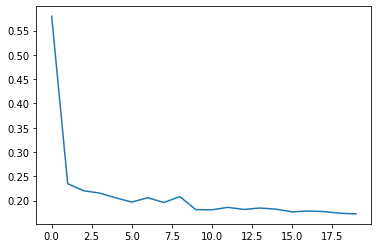

In [262]:
plt.plot(torch.tensor(losses).view(-1, 50).mean(1))

In [263]:
sample_ix = 61
out, embs, codes, q_loss =  model(xs[sample_ix][None,...].to(device))
Audio(out.squeeze().tolist(), rate=sr)

In [259]:
Audio(xs[sample_ix].squeeze().tolist(), rate=sr)

In [257]:
out.squeeze()[:30], xs[sample_ix].squeeze()[:30]

(tensor([ 0.1399,  0.1034, -0.0203, -0.0208,  0.0030,  0.0110,  0.0275,  0.0241,
          0.0109,  0.0131,  0.0284,  0.0182,  0.0193,  0.0141,  0.0224,  0.0173,
          0.0034,  0.0063,  0.0156,  0.0278,  0.0132,  0.0125,  0.0160,  0.0144,
          0.0148,  0.0110,  0.0315,  0.0412,  0.0342,  0.0287], device='cuda:1',
        grad_fn=<SliceBackward0>),
 tensor([-0.0161, -0.0025,  0.0094,  0.0213,  0.0377,  0.0488,  0.0485,  0.0440,
          0.0427,  0.0397,  0.0385,  0.0369,  0.0274,  0.0233,  0.0221,  0.0304,
          0.0374,  0.0272,  0.0135,  0.0010, -0.0027, -0.0069, -0.0189, -0.0348,
         -0.0553, -0.0703, -0.0697, -0.0515, -0.0238,  0.0002]))